In [9]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset
import numpy as np
import PIL.Image as Image
from torchvision import transforms
import torchvision.models
import torch.nn as nn
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [10]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)



class RetinopathyLoader(Dataset):
    def __init__(self, root, mode,transform=None):
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        if transform == None:
            self.transform = transforms.ToTensor()
        else: self.transform = transform
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):
        
        path = self.root + self.img_name[index] + '.jpeg'
        img = Image.open(path , mode='r')

        if self.transform!=None:
            img = self.transform(img)

        label = self.label[index]

        return img, label
def LoadData(param):
    p={}
    data_loader = RetinopathyLoader('data/','test',transform=param['transforms'])
    p['test_size'] = len(data_loader)
    p['test_data'] = DataLoader(data_loader, batch_size=param['batch'],shuffle=True)  
    return p


In [3]:
class ResNet(nn.Module):
    def __init__(self, pretrained=True,layers=18):
        super(ResNet, self).__init__()

        f = lambda x : "with" if x else "w/o" 
        self.pretrained = f(pretrained)
        self.layer_num = layers
        

        pretrained_model = torchvision.models.__dict__[f'resnet{layers}'](pretrained)
        self.conv1 = pretrained_model._modules['conv1']
        self.bn1 = pretrained_model._modules['bn1']
        self.relu = pretrained_model._modules['relu']
        self.maxpool = pretrained_model._modules['maxpool']

        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.classify = nn.Linear(pretrained_model._modules['fc'].in_features, 5)

        del pretrained_model

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classify(x)

        return x

In [4]:
param = { 
    "epochs":1,#10,
    "batch":4,
    "learning_rate":1e-3,
    "Loss":"CrossEntropy",
    "optimizer":{
        "name":"SGD",
        "momentum":0.9,
        "weight_decay":5e-4
    },
    'model':{
        'layer':18,
        'pretrained':True
    },
    'transforms':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.1, 0.1, 0.1]), 
    ])
}


In [6]:
def generate_cm(layer,pre,bound=None):
    model = ResNet(pre,layer)
    if bound==None:model.load_state_dict(torch.load(f"./model/resnet{layer}_{pre}.pth",map_location=torch.device('cpu')))
    else:model.load_state_dict(torch.load(f"./model/resnet{layer}_{pre}_{bound}.pth",map_location=torch.device('cpu')))
    model.eval()#固定BN用

    test_data = LoadData(param)

    y_pred,y_true = [],[]
    test_acc = 0
    with torch.no_grad():
        for idx,(data,target) in enumerate(tqdm(test_data['test_data'])):
            data = data.to(dtype=torch.float)
            target = target.to(dtype=torch.long)
            predict = model(data)
            
            _, preds = torch.max(predict, 1)      
            y_pred.extend(preds.view(-1).detach().cpu().numpy())       
            y_true.extend(target.view(-1).detach().cpu().numpy())
            test_acc  += (torch.max(predict,dim=1).indices==target).sum().item()
            
    print(f"test acc:{round(100* test_acc/7025,2)}%") 
    cf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[0,1,2,3,4])
    disp.plot()
    if bound==None:plt.savefig(f'resnet{layer}_{pre}_cm.png')
    else:plt.savefig(f'resnet{layer}_{pre}_{bound}_cm.png')
    
    

> Found 7025 images...


100%|██████████| 1757/1757 [1:12:33<00:00,  2.48s/it]


test acc:80.77%


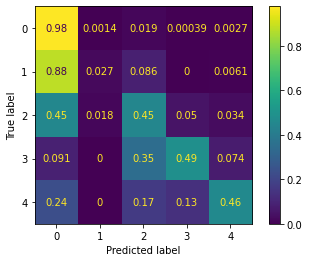

In [49]:
generate_cm(50,True,80)